# Comparing Designs Across Experimental Setups

This tutorial addresses a critical question when optimizing your fMRI designs:  
**When can you compare efficiency metrics between different experimental configurations, and when can't you?**

We'll work through concrete examples showing how to properly compare ITI models, stimulus timing strategies, and other parameters on equal footing.

---

## 1. Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neurodesign import classes, generate

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 100

## 2. What Makes Metrics Comparable?

Fe (estimation efficiency) is computed as:

$$
F_e = \frac{n_{\text{contrasts}}}{\text{trace}(\mathbf{C} \cdot (\mathbf{X}^T \mathbf{W} \mathbf{X})^{-1} \cdot \mathbf{C}^T)}
$$

The design matrix **X** varies between designs — that's what we optimize. But the whitening matrix **W** is a property of the *experimental container*. It depends on:

- **`n_scans`** = ceil(duration / TR)  
- **`rho`** (temporal autocorrelation)
- **Drift polynomials** (derived from `n_scans`)

Two Experiments with the same `duration`, `TR`, and `rho` produce **identical W**. Their Fe values are directly, linearly comparable. Two Experiments with *different* W values are like rulers measured in different units — you cannot compare the numbers.

Let's see this concretely.

## 3. Case 1: Comparing Designs Within One Experiment

This is the simplest and most common case. All designs share a single `Experiment` object, so they share the same `W`. Fe values are always directly comparable.


In [3]:
# Define one experiment
exp = classes.Experiment(
    TR=2,
    n_trials=20,
    P=[0.3, 0.3, 0.4],
    C=[[1, -1, 0], [0, 1, -1]],
    n_stimuli=3,
    rho=0.3,
    stim_duration=1,
    t_pre=0.5,
    t_post=2,
    ITImodel="exponential",
    ITImin=2,
    ITImax=4,
    ITImean=2.1,
)

# Design 1: cyclic order, fixed ITI
design_1 = classes.Design(
    order=[0, 1, 2] * 6 + [0, 1],
    ITI=[2] * 20,
    experiment=exp,
)
design_1.designmatrix()
design_1.FeCalc()
design_1.FdCalc()

# Design 2: blocked order, same fixed ITI
design_2 = classes.Design(
    order=[0, 0, 1, 1, 2, 2] * 3 + [0, 1],
    ITI=[2] * 20,
    experiment=exp,
)
design_2.designmatrix()
design_2.FeCalc()
design_2.FdCalc()

# Design 3: blocked order, jittered ITI
iti_jittered = generate.iti(ntrials=20, model="exponential", min=1, mean=2, max=4, seed=42)[0]
design_3 = classes.Design(
    order=[0, 0, 1, 1, 2, 2] * 3 + [0, 1],
    ITI=iti_jittered,
    experiment=exp,
)
design_3.designmatrix()
design_3.FeCalc()
design_3.FdCalc()

print("All designs share the same Experiment:")
print(f"  Same object? {id(design_1.experiment) == id(design_2.experiment) == id(design_3.experiment)}")
print(f"  n_scans = {exp.n_scans}, W shape = {exp.white.shape}")
print()
print(f"{'Design':<12} {'Fe (raw)':>12} {'Fd (raw)':>12} {'Fe ratio vs D1':>16}")
print("-" * 54)
for name, d in [("Cyclic", design_1), ("Blocked", design_2), ("Block+jitter", design_3)]:
    print(f"{name:<12} {d.Fe:>12.2f} {d.Fd:>12.2f} {d.Fe / design_1.Fe:>16.2f}x")

c:\Users\vguigon\Desktop\Research_directory\Lab_SLD\neurodesign-plus\neurodesign\classes.py:638: UserWarning: the resolution is adjusted to be a multiple of the TR. New resolution: 0.1
  warnings.warn(
c:\Users\vguigon\Desktop\Research_directory\Lab_SLD\neurodesign-plus\neurodesign\classes.py:806: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


All designs share the same Experiment:
  Same object? True
  n_scans = 56, W shape = (56, 56)

Design           Fe (raw)     Fd (raw)   Fe ratio vs D1
------------------------------------------------------
Cyclic              19.98         0.16             1.00x
Blocked            112.66         0.19             5.64x
Block+jitter       171.28         0.21             8.57x


**Key takeaway:** Within one Experiment, Fe ratios are directly meaningful. If Design A has 2× the Fe of Design B, it provides contrast estimates with half the variance.


## 4. Case 2: Comparing Across `n_trials` with Different ITI Models

A natural question: *"Is an exponential ITI model better than a uniform one?"*

The naive approach — create two Experiments with `n_trials=20` but different ITI models — **gives misleading results**. Here's why:


In [4]:
# WRONG: Different ITImean → different duration → different W
exp_exp = classes.Experiment(
    TR=2, n_trials=20,
    P=[0.3, 0.3, 0.4], C=[[1, -1, 0], [0, 1, -1]],
    n_stimuli=3, rho=0.3, stim_duration=1, t_pre=0.5, t_post=2,
    ITImodel="exponential", ITImin=2, ITImax=4, ITImean=2.1,
)

exp_uni = classes.Experiment(
    TR=2, n_trials=20,
    P=[0.3, 0.3, 0.4], C=[[1, -1, 0], [0, 1, -1]],
    n_stimuli=3, rho=0.3, stim_duration=1, t_pre=0.5, t_post=2,
    ITImodel="uniform", ITImin=1, ITImax=5, ITImean=3.0,
)

print("Comparing Experiments with n_trials=20:")
print(f"  Exponential: duration = {exp_exp.duration:.1f}s, n_scans = {exp_exp.n_scans}, W shape = {np.array(exp_exp.white).shape}")
print(f"  Uniform:     duration = {exp_uni.duration:.1f}s, n_scans = {exp_uni.n_scans}, W shape = {np.array(exp_uni.white).shape}")
print(f"  Same shape? {np.array(exp_exp.white).shape == np.array(exp_uni.white).shape}")
print(f"  Same W? {np.allclose(np.array(exp_exp.white), np.array(exp_uni.white)[:min(exp_exp.n_scans, exp_uni.n_scans), :min(exp_exp.n_scans, exp_uni.n_scans)])}")
print()
print("These Fe values are NOT comparable — different W means different ruler!")

Comparing Experiments with n_trials=20:
  Exponential: duration = 112.0s, n_scans = 56, W shape = (56, 56)
  Uniform:     duration = 130.0s, n_scans = 65, W shape = (65, 65)
  Same shape? False
  Same W? False

These Fe values are NOT comparable — different W means different ruler!


The exponential experiment (ITImean=2.1) has a shorter total duration than the uniform experiment (ITImean=3.0). Fewer scans means a different whitening matrix, so Fe is computed on a different scale. Comparing raw Fe between them is like comparing meters to feet.


## 5. Case 3: The Right Way — Fix Duration, Let Trials Vary

To compare ITI models properly, **fix the total duration**. Both experiments get the same number of scans, the same whitening matrix, and Fe is directly comparable.

Duration imposes a tradeoff: a shorter mean ITI fits more trials into the same window (more data points), while a longer mean ITI gives each trial more temporal separation (less overlap, potentially better deconvolution).


In [5]:
DURATION = 200  # Fix total duration for both experiments

exp_exp_fixed = classes.Experiment(
    TR=2, duration=DURATION,    # ← duration, not n_trials
    P=[0.3, 0.3, 0.4], C=[[1, -1, 0], [0, 1, -1]],
    n_stimuli=3, rho=0.3, stim_duration=1, t_pre=0.5, t_post=2,
    ITImodel="exponential", ITImin=2, ITImax=4, ITImean=2.1,
)

exp_uni_fixed = classes.Experiment(
    TR=2, duration=DURATION,    # ← same duration
    P=[0.3, 0.3, 0.4], C=[[1, -1, 0], [0, 1, -1]],
    n_stimuli=3, rho=0.3, stim_duration=1, t_pre=0.5, t_post=2,
    ITImodel="uniform", ITImin=1, ITImax=5, ITImean=3.0,
)

print("Comparing Experiments with duration=200:")
print(f"  Exponential: n_trials = {exp_exp_fixed.n_trials}, n_scans = {exp_exp_fixed.n_scans}")
print(f"  Uniform:     n_trials = {exp_uni_fixed.n_trials}, n_scans = {exp_uni_fixed.n_scans}")
print(f"  Same W? {np.allclose(np.array(exp_exp_fixed.white), np.array(exp_uni_fixed.white))}")

Comparing Experiments with duration=200:
  Exponential: n_trials = 35, n_scans = 100
  Uniform:     n_trials = 30, n_scans = 100
  Same W? True


In [8]:
# Sample many designs under each ITI model and compare Fe distributions
def sample_fe_distribution(exp, n_samples=10, seed=42):
    """Sample random designs and collect raw Fe values."""
    rng = np.random.RandomState(seed)
    fes = []
    fds = []
    for _ in range(n_samples):
        order = list(rng.choice(exp.n_stimuli, size=exp.n_trials, p=exp.P))
        iti, _ = generate.iti(
            ntrials=exp.n_trials, model=exp.ITImodel,
            min=exp.ITImin, max=exp.ITImax, mean=exp.ITImean,
            seed=rng.randint(100000), resolution=exp.resolution,
        )
        try:
            des = classes.Design(order=order, ITI=np.array(iti), experiment=exp)
            result = des.designmatrix()
            if result is False:
                continue
            des.FeCalc()
            des.FdCalc()
            fes.append(des.Fe)
            fds.append(des.Fd)
        except Exception:
            continue
    return np.array(fes), np.array(fds)

fes_exp, fds_exp = sample_fe_distribution(exp_exp_fixed)
fes_uni, fds_uni = sample_fe_distribution(exp_uni_fixed)

print(f"{'Metric':<6} {'Exponential':>20} {'Uniform':>20} {'Ratio (exp/uni)':>16}")
print("-" * 64)
print(f"{'Fe':<6} {fes_exp.mean():>12.2f} ± {fes_exp.std():>5.2f} "
      f"{fes_uni.mean():>12.2f} ± {fes_uni.std():>5.2f} "
      f"{fes_exp.mean()/fes_uni.mean():>14.2f}x")
print(f"{'Fd':<6} {fds_exp.mean():>12.2f} ± {fds_exp.std():>5.2f} "
      f"{fds_uni.mean():>12.2f} ± {fds_uni.std():>5.2f} "
      f"{fds_exp.mean()/fds_uni.mean():>14.2f}x")

Metric          Exponential              Uniform  Ratio (exp/uni)
----------------------------------------------------------------
Fe            67.94 ±  5.56        73.69 ±  5.23           0.92x
Fd             0.28 ±  0.02         0.25 ±  0.02           1.15x


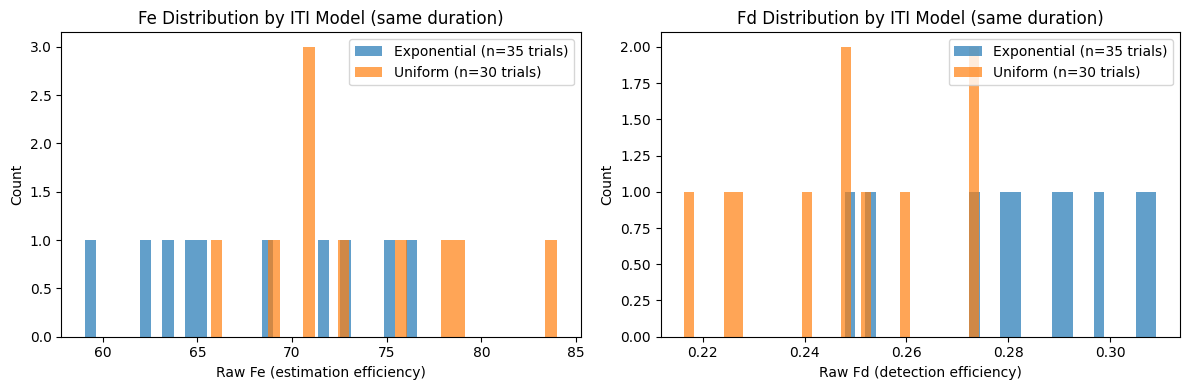

In [9]:
# Visualize the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(fes_exp, bins=30, alpha=0.7, label=f"Exponential (n={exp_exp_fixed.n_trials} trials)")
axes[0].hist(fes_uni, bins=30, alpha=0.7, label=f"Uniform (n={exp_uni_fixed.n_trials} trials)")
axes[0].set_xlabel("Raw Fe (estimation efficiency)")
axes[0].set_ylabel("Count")
axes[0].set_title("Fe Distribution by ITI Model (same duration)")
axes[0].legend()

axes[1].hist(fds_exp, bins=30, alpha=0.7, label=f"Exponential (n={exp_exp_fixed.n_trials} trials)")
axes[1].hist(fds_uni, bins=30, alpha=0.7, label=f"Uniform (n={exp_uni_fixed.n_trials} trials)")
axes[1].set_xlabel("Raw Fd (detection efficiency)")
axes[1].set_ylabel("Count")
axes[1].set_title("Fd Distribution by ITI Model (same duration)")
axes[1].legend()

plt.tight_layout()
plt.show()

Because both experiments have the same duration (and therefore the same W), these Fe and Fd values are directly comparable. The difference you see reflects the genuine impact of the ITI model on design efficiency.

Note how the exponential model gets more trials into the same window (shorter mean ITI).  

More trials generally means higher Fe, but it also means more temporal overlap between HRFs, which can hurt estimation. The distributions show this tradeoff, with in our present case exponential ITI increasing the Fd but uniform ITI dominating the Fe increase.


## 6. Systematic Comparison: Sweeping a Parameter

Let's sweep across ITI mean values to see how the amount of temporal jitter affects efficiency. We fix duration=200 throughout, so all comparisons are fair.


In [11]:
iti_means = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]
results = []

for mean_iti in iti_means:
    try:
        exp_sweep = classes.Experiment(
            TR=2, duration=200,
            P=[0.3, 0.3, 0.4], C=[[1, -1, 0], [0, 1, -1]],
            n_stimuli=3, rho=0.3, stim_duration=1, t_pre=0.5, t_post=2,
            ITImodel="exponential",
            ITImin=max(0.5, mean_iti - 1),
            ITImax=mean_iti + 2,
            ITImean=mean_iti,
        )
    except Exception as e:
        print(f"  ITImean={mean_iti}: skipped ({e})")
        continue
    
    fes, fds = sample_fe_distribution(exp_sweep, n_samples=10, seed=42)
    
    if len(fes) > 0:
        results.append({
            "iti_mean": mean_iti,
            "n_trials": exp_sweep.n_trials,
            "fe_mean": fes.mean(),
            "fe_std": fes.std(),
            "fd_mean": fds.mean(),
            "fd_std": fds.std(),
        })

print(f"{'ITImean':>8} {'n_trials':>9} {'Fe mean':>10} {'Fe std':>8} {'Fd mean':>10} {'Fd std':>8}")
print("-" * 56)
for r in results:
    print(f"{r['iti_mean']:>8.1f} {r['n_trials']:>9d} "
          f"{r['fe_mean']:>10.2f} {r['fe_std']:>8.2f} "
          f"{r['fd_mean']:>10.2f} {r['fd_std']:>8.2f}")

C:\Users\vguigon\AppData\Local\Temp\ipykernel_25048\853093107.py:19: DeprecationWarning: The numpy.linalg.linalg has been made private and renamed to numpy.linalg._linalg. All public functions exported by it are available from numpy.linalg. Please use numpy.linalg.LinAlgError instead.
  des.FeCalc()


 ITImean  n_trials    Fe mean   Fe std    Fd mean   Fd std
--------------------------------------------------------
     1.5        40      92.97     7.99       0.30     0.03
     2.0        36      84.01     6.47       0.29     0.03
     2.5        33      81.75     6.90       0.26     0.02
     3.0        30        nan      nan       0.25     0.02
     3.5        28      70.37     9.39       0.22     0.02
     4.0        26      63.11     5.78       0.21     0.02
     5.0        23      59.27     3.83       0.18     0.02


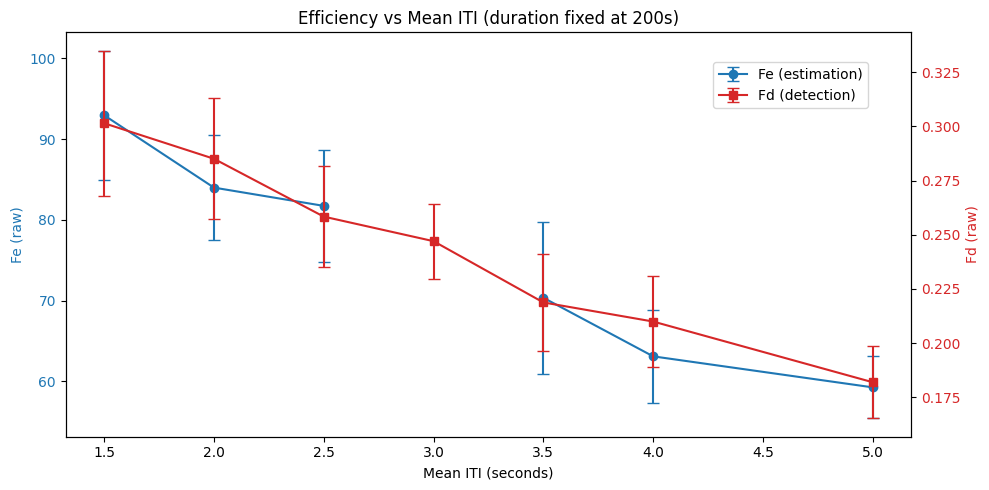

In [12]:
# Plot the tradeoff
fig, ax1 = plt.subplots(figsize=(10, 5))

iti_vals = [r["iti_mean"] for r in results]
fe_vals = [r["fe_mean"] for r in results]
fd_vals = [r["fd_mean"] for r in results]
fe_errs = [r["fe_std"] for r in results]
fd_errs = [r["fd_std"] for r in results]
trial_counts = [r["n_trials"] for r in results]

color_fe = "tab:blue"
color_fd = "tab:red"

ax1.errorbar(iti_vals, fe_vals, yerr=fe_errs, color=color_fe, marker="o", 
             capsize=4, label="Fe (estimation)")
ax1.set_xlabel("Mean ITI (seconds)")
ax1.set_ylabel("Fe (raw)", color=color_fe)
ax1.tick_params(axis="y", labelcolor=color_fe)

ax2 = ax1.twinx()
ax2.errorbar(iti_vals, fd_vals, yerr=fd_errs, color=color_fd, marker="s", 
             capsize=4, label="Fd (detection)")
ax2.set_ylabel("Fd (raw)", color=color_fd)
ax2.tick_params(axis="y", labelcolor=color_fd)

# Annotate trial counts
for x, n in zip(iti_vals, trial_counts):
    ax1.annotate(f"n={n}", (x, 0), textcoords="offset points", 
                xytext=(0, -20), ha="center", fontsize=8, color="gray")

ax1.set_title("Efficiency vs Mean ITI (duration fixed at 200s)")
fig.legend(loc="upper right", bbox_to_anchor=(0.88, 0.88))
plt.tight_layout()
plt.show()

This shows the tradeoff:

- **Short ITIs → more trials → generally higher Fe** (more data points for deconvolution), but diminishing returns as overlap increases
- **Long ITIs → fewer trials → generally higher Fd per trial** (cleaner HRF separation), but fewer data points

The exact crossover point depends on your specific contrast structure, number of conditions, and HRF characteristics. This sweep helps you identify the sweet spot for your experiment.

All these comparisons are valid because every experiment has `duration=200` → same `n_scans` → same `W`.


## 7. Fc and Ff: Always Comparable

Unlike Fe and Fd, the confounding efficiency (Fc) and frequency accuracy (Ff) do not depend on the whitening matrix at all. They depend only on:

- The stimulus order (sequence of condition labels)
- The target probabilities `P`
- The number of stimuli

This means **Fc and Ff are always comparable** across any two designs with the same number of conditions and target probabilities, regardless of timing parameters.


In [13]:
# Demonstrate: same order in two different experiments → same Fc, Ff
order = [0, 1, 2] * 6 + [0, 1]

exp_short = classes.Experiment(
    TR=2, duration=100,
    P=[0.3, 0.3, 0.4], C=[[1, -1, 0], [0, 1, -1]],
    n_stimuli=3, rho=0.3, stim_duration=1,
    ITImodel="fixed", ITImean=2.0, ITImin=1.0, ITImax=3.0,
)

exp_long = classes.Experiment(
    TR=2, duration=300,
    P=[0.3, 0.3, 0.4], C=[[1, -1, 0], [0, 1, -1]],
    n_stimuli=3, rho=0.3, stim_duration=1,
    ITImodel="fixed", ITImean=2.0, ITImin=1.0, ITImax=3.0,
)

# Use same order (truncated to fit each experiment's n_trials)
for label, this_exp in [("Short (100s)", exp_short), ("Long (300s)", exp_long)]:
    this_order = (order * 10)[:this_exp.n_trials]  # repeat to fill
    iti = [2.0] * this_exp.n_trials
    des = classes.Design(order=this_order, ITI=np.array(iti), experiment=this_exp)
    des.designmatrix()
    des.FcCalc()
    des.FfCalc()
    des.FeCalc()
    print(f"{label:>15}: n_trials={this_exp.n_trials:>3d}, "
          f"Fc={des.Fc:.4f}, Ff={des.Ff:.4f}, Fe={des.Fe:.2f}")

print()
print("Fc and Ff are properties of the ORDER, not the timing.")
print("Fe differs because the whitening matrix differs (different duration).")

   Short (100s): n_trials= 33, Fc=0.3490, Ff=0.8615, Fe=56.62
    Long (300s): n_trials=100, Fc=0.3603, Ff=0.8571, Fe=97.10

Fc and Ff are properties of the ORDER, not the timing.
Fe differs because the whitening matrix differs (different duration).


## 8. Decision Guide: How to Compare

| You want to compare... | Hold constant | Compare using |
|---|---|---|
| Two stimulus orders (same timing) | Same Experiment | Raw Fe, Fd, Fc, Ff |
| Two ITI models | `duration`, `TR`, `rho` | Raw Fe, Fd |
| Two stim durations | `duration`, `TR`, `rho` | Raw Fe, Fd |
| Two contrast matrices | `duration`, `TR`, `rho`, ITI params | Raw Fe, Fd |
| Two TRs | Nothing works | Power simulation |
| Two rho values | Nothing works | Power simulation |
| "Should I run 20 or 40 trials?" | Nothing works | Power simulation |

**Rules of thumb:**
1. If it changes `n_scans`, you cannot compare Fe/Fd directly.
2. If it only changes the design matrix (order, stim timing, contrasts), you can.
3. When in doubt, check `np.allclose(exp_A.white, exp_B.white)`.


## 9. Running Optimization for Both Setups

When you use `Optimisation.optimise()`, the pre-run calibrates FeMax and FdMax for each Experiment independently. After calibration, Fe ∈ [0, 1] within each run — but these normalized values are **not comparable across runs** (each has its own ceiling).

To compare optimized designs across experiments, extract the raw Fe from the best design:


In [16]:
# Run short optimizations for both ITI models
# (increase cycles for real use — here we use small values for speed)

opt_exp = classes.Optimisation(
    experiment=exp_exp_fixed,
    weights=[0.5, 0.25, 0.125, 0.125],
    preruncycles=0,
    cycles=5,
    seed=42,
)
opt_exp.optimise()

opt_uni = classes.Optimisation(
    experiment=exp_uni_fixed,
    weights=[0.5, 0.25, 0.125, 0.125],
    preruncycles=0,
    cycles=5,
    seed=42,
)
opt_uni.optimise()

# Compare the best designs using RAW Fe (multiply by FeMax to undo normalization)
best_exp = opt_exp.bestdesign
best_uni = opt_uni.bestdesign

raw_fe_exp = best_exp.Fe * exp_exp_fixed.FeMax
raw_fe_uni = best_uni.Fe * exp_uni_fixed.FeMax
raw_fd_exp = best_exp.Fd * exp_exp_fixed.FdMax
raw_fd_uni = best_uni.Fd * exp_uni_fixed.FdMax

print("Best optimized designs (raw metrics — directly comparable):")
print(f"  Exponential ITI: raw Fe = {raw_fe_exp:.2f}, raw Fd = {raw_fd_exp:.2f}")
print(f"  Uniform ITI:     raw Fe = {raw_fe_uni:.2f}, raw Fd = {raw_fd_uni:.2f}")
print(f"  Fe ratio: {raw_fe_exp / raw_fd_uni:.2f}x")
print()
print("Normalized metrics (NOT comparable across experiments):")
print(f"  Exponential ITI: Fe = {best_exp.Fe:.4f}, Fd = {best_exp.Fd:.4f}")
print(f"  Uniform ITI:     Fe = {best_uni.Fe:.4f}, Fd = {best_uni.Fd:.4f}")

Output()

Output()

Best optimized designs (raw metrics — directly comparable):
  Exponential ITI: raw Fe = 83.09, raw Fd = 0.30
  Uniform ITI:     raw Fe = 93.06, raw Fd = 0.27
  Fe ratio: 311.36x

Normalized metrics (NOT comparable across experiments):
  Exponential ITI: Fe = 0.9702, Fd = 0.3747
  Uniform ITI:     Fe = 0.9584, Fd = 0.3444


## 10. Summary

1. **Within one Experiment**, all efficiency metrics are always comparable. Higher is better. Ratios are meaningful.

2. **Across Experiments**, Fe and Fd are comparable **only if the whitening matrix is identical** (same `duration`, `TR`, `rho`). Use `duration=` instead of `n_trials=` to guarantee this.

3. **Fc and Ff** depend only on the stimulus order and probabilities. They are always comparable regardless of timing parameters.

4. **Normalized Fe** (after calibration by `optimise()`) tells you how close you are to the ceiling *for that specific setup*. It does **not** tell you which setup is better. For cross-setup comparison, use the raw (uncalibrated) values.

5. **When W differs** (different duration, TR, or rho), direct Fe/Fd comparison is invalid. Use power simulation instead.

6. The quick check: `np.allclose(exp_A.white, exp_B.white)` — if `True`, compare away.
